<a href="https://colab.research.google.com/github/alexjercan/depth-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

In [1]:
!git clone https://github.com/alexjercan/depth-estimation.git
%cd depth-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# Download model
torch.hub.download_url_to_file('https://github.com/alexjercan/depth-estimation/releases/download/v1.0/normal.pth', 'normal.pth')

In [ ]:
# Download dataset stereo
!bash ./get_bdataset.sh

In [ ]:
!git pull
!python dataset.py
!python model.py

In [21]:
import os
import re
import cv2
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_stereo"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [
    {
      "imageL": "data/0000L.png",
      "imageR": "data/0000R.png",
      "output": "data/out/0000.exr",
    },
    {
      "imageL": "data/0001L.png",
      "imageR": "data/0001R.png",
      "output": "data/out/0001.exr",
    },
    {
      "imageL": "data/0002L.png",
      "imageR": "data/0002R.png",
      "output": "data/out/0002.exr",
    }
]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.9
DAMPENING = 0.1

MILESTONES = [10,20,30]
GAMMA = 0.2

NUM_EPOCHS = 40
OUT_PATH ="./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [11]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        M.MyHorizontalFlip(p=0.5),
        M.MyVerticalFlip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_depth': 'depth',
        'right_depth': 'depth',
    }
)

detect_transform = A.Compose(
        [
            A.LongestMaxSize(max_size=IMAGE_SIZE),
            A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
            A.Normalize(),
            M.MyToTensorV2(),
        ],
    additional_targets={
        'right_img': 'image',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)


In [12]:
model = Model()
model.apply(init_weights)
solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                         lr=LEARNING_RATE, momentum=MOMENTUM,
                         dampening = DAMPENING, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [13]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()

  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 0, loss=(total:0.2533)
======DEPTH=======
MSE=0.0933	RMSE=0.2860	MAE=0.1224	ABS_REL=0.1224
DELTA1.02=0.3478	DELTA1.05=0.6344	DELTA1.10=0.8180
DELTA1.25=0.9113	DELTA1.25^2=0.9517	DELTA1.25^3=0.9684



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 1, loss=(total:0.0576)
======DEPTH=======
MSE=0.0438	RMSE=0.2037	MAE=0.0672	ABS_REL=0.0672
DELTA1.02=0.4396	DELTA1.05=0.7710	DELTA1.10=0.9285
DELTA1.25=0.9673	DELTA1.25^2=0.9811	DELTA1.25^3=0.9869



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 2, loss=(total:0.0752)
======DEPTH=======
MSE=0.0247	RMSE=0.1552	MAE=0.0550	ABS_REL=0.0550
DELTA1.02=0.3698	DELTA1.05=0.7572	DELTA1.10=0.9266
DELTA1.25=0.9824	DELTA1.25^2=0.9889	DELTA1.25^3=0.9918



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 3, loss=(total:0.0362)
======DEPTH=======
MSE=0.0496	RMSE=0.2048	MAE=0.0606	ABS_REL=0.0606
DELTA1.02=0.4991	DELTA1.05=0.8904	DELTA1.10=0.9639
DELTA1.25=0.9783	DELTA1.25^2=0.9857	DELTA1.25^3=0.9898



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 4, loss=(total:0.0561)
======DEPTH=======
MSE=0.0211	RMSE=0.1442	MAE=0.0410	ABS_REL=0.0410
DELTA1.02=0.4999	DELTA1.05=0.8939	DELTA1.10=0.9772
DELTA1.25=0.9862	DELTA1.25^2=0.9906	DELTA1.25^3=0.9931



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 5, loss=(total:0.0312)
======DEPTH=======
MSE=0.0191	RMSE=0.1371	MAE=0.0351	ABS_REL=0.0351
DELTA1.02=0.6105	DELTA1.05=0.9332	DELTA1.10=0.9818
DELTA1.25=0.9878	DELTA1.25^2=0.9916	DELTA1.25^3=0.9938



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 6, loss=(total:0.0732)
======DEPTH=======
MSE=0.0203	RMSE=0.1393	MAE=0.0333	ABS_REL=0.0333
DELTA1.02=0.7356	DELTA1.05=0.9363	DELTA1.10=0.9815
DELTA1.25=0.9874	DELTA1.25^2=0.9914	DELTA1.25^3=0.9937



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 7, loss=(total:0.0554)
======DEPTH=======
MSE=0.0206	RMSE=0.1394	MAE=0.0368	ABS_REL=0.0368
DELTA1.02=0.5971	DELTA1.05=0.9207	DELTA1.10=0.9820
DELTA1.25=0.9884	DELTA1.25^2=0.9920	DELTA1.25^3=0.9941



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 8, loss=(total:0.0347)
======DEPTH=======
MSE=0.0420	RMSE=0.1835	MAE=0.0448	ABS_REL=0.0448
DELTA1.02=0.7790	DELTA1.05=0.9533	DELTA1.10=0.9749
DELTA1.25=0.9837	DELTA1.25^2=0.9888	DELTA1.25^3=0.9919



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 9, loss=(total:0.0375)
======DEPTH=======
MSE=0.0252	RMSE=0.1525	MAE=0.0340	ABS_REL=0.0340
DELTA1.02=0.7998	DELTA1.05=0.9687	DELTA1.10=0.9803
DELTA1.25=0.9868	DELTA1.25^2=0.9912	DELTA1.25^3=0.9935



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 10, loss=(total:0.0372)
======DEPTH=======
MSE=0.0179	RMSE=0.1330	MAE=0.0202	ABS_REL=0.0202
DELTA1.02=0.9466	DELTA1.05=0.9800	DELTA1.10=0.9851
DELTA1.25=0.9892	DELTA1.25^2=0.9924	DELTA1.25^3=0.9944



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 11, loss=(total:0.0264)
======DEPTH=======
MSE=0.0212	RMSE=0.1358	MAE=0.0210	ABS_REL=0.0210
DELTA1.02=0.9651	DELTA1.05=0.9802	DELTA1.10=0.9848
DELTA1.25=0.9890	DELTA1.25^2=0.9923	DELTA1.25^3=0.9944



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 12, loss=(total:0.0292)
======DEPTH=======
MSE=0.0189	RMSE=0.1320	MAE=0.0197	ABS_REL=0.0197
DELTA1.02=0.9658	DELTA1.05=0.9807	DELTA1.10=0.9852
DELTA1.25=0.9893	DELTA1.25^2=0.9925	DELTA1.25^3=0.9945



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 13, loss=(total:0.0284)
======DEPTH=======
MSE=0.0170	RMSE=0.1294	MAE=0.0185	ABS_REL=0.0185
DELTA1.02=0.9679	DELTA1.05=0.9816	DELTA1.10=0.9859
DELTA1.25=0.9898	DELTA1.25^2=0.9928	DELTA1.25^3=0.9947



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 14, loss=(total:0.0250)
======DEPTH=======
MSE=0.0182	RMSE=0.1318	MAE=0.0192	ABS_REL=0.0192
DELTA1.02=0.9690	DELTA1.05=0.9818	DELTA1.10=0.9861
DELTA1.25=0.9900	DELTA1.25^2=0.9929	DELTA1.25^3=0.9947



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 15, loss=(total:0.0265)
======DEPTH=======
MSE=0.0175	RMSE=0.1311	MAE=0.0191	ABS_REL=0.0191
DELTA1.02=0.9661	DELTA1.05=0.9810	DELTA1.10=0.9857
DELTA1.25=0.9899	DELTA1.25^2=0.9929	DELTA1.25^3=0.9947



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 16, loss=(total:0.0263)
======DEPTH=======
MSE=0.0171	RMSE=0.1297	MAE=0.0183	ABS_REL=0.0183
DELTA1.02=0.9684	DELTA1.05=0.9819	DELTA1.10=0.9863
DELTA1.25=0.9903	DELTA1.25^2=0.9932	DELTA1.25^3=0.9949



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 17, loss=(total:0.0189)
======DEPTH=======
MSE=0.0188	RMSE=0.1309	MAE=0.0192	ABS_REL=0.0192
DELTA1.02=0.9700	DELTA1.05=0.9826	DELTA1.10=0.9868
DELTA1.25=0.9904	DELTA1.25^2=0.9932	DELTA1.25^3=0.9949



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 18, loss=(total:0.0303)
======DEPTH=======
MSE=0.0172	RMSE=0.1289	MAE=0.0184	ABS_REL=0.0184
DELTA1.02=0.9713	DELTA1.05=0.9830	DELTA1.10=0.9868
DELTA1.25=0.9903	DELTA1.25^2=0.9930	DELTA1.25^3=0.9947



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 19, loss=(total:0.0209)
======DEPTH=======
MSE=0.0198	RMSE=0.1334	MAE=0.0198	ABS_REL=0.0198
DELTA1.02=0.9691	DELTA1.05=0.9820	DELTA1.10=0.9864
DELTA1.25=0.9903	DELTA1.25^2=0.9931	DELTA1.25^3=0.9948



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 20, loss=(total:0.0221)
======DEPTH=======
MSE=0.0170	RMSE=0.1298	MAE=0.0170	ABS_REL=0.0170
DELTA1.02=0.9726	DELTA1.05=0.9829	DELTA1.10=0.9868
DELTA1.25=0.9905	DELTA1.25^2=0.9932	DELTA1.25^3=0.9949



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 21, loss=(total:0.0366)
======DEPTH=======
MSE=0.0184	RMSE=0.1340	MAE=0.0180	ABS_REL=0.0180
DELTA1.02=0.9718	DELTA1.05=0.9825	DELTA1.10=0.9866
DELTA1.25=0.9905	DELTA1.25^2=0.9932	DELTA1.25^3=0.9949



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 22, loss=(total:0.0168)
======DEPTH=======
MSE=0.0165	RMSE=0.1276	MAE=0.0167	ABS_REL=0.0167
DELTA1.02=0.9723	DELTA1.05=0.9828	DELTA1.10=0.9868
DELTA1.25=0.9905	DELTA1.25^2=0.9933	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 23, loss=(total:0.0229)
======DEPTH=======
MSE=0.0164	RMSE=0.1273	MAE=0.0165	ABS_REL=0.0165
DELTA1.02=0.9723	DELTA1.05=0.9833	DELTA1.10=0.9871
DELTA1.25=0.9907	DELTA1.25^2=0.9934	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 24, loss=(total:0.0173)
======DEPTH=======
MSE=0.0167	RMSE=0.1282	MAE=0.0167	ABS_REL=0.0167
DELTA1.02=0.9722	DELTA1.05=0.9833	DELTA1.10=0.9872
DELTA1.25=0.9907	DELTA1.25^2=0.9934	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 25, loss=(total:0.0219)
======DEPTH=======
MSE=0.0166	RMSE=0.1281	MAE=0.0166	ABS_REL=0.0166
DELTA1.02=0.9730	DELTA1.05=0.9832	DELTA1.10=0.9872
DELTA1.25=0.9907	DELTA1.25^2=0.9933	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 26, loss=(total:0.0346)
======DEPTH=======
MSE=0.0200	RMSE=0.1318	MAE=0.0186	ABS_REL=0.0186
DELTA1.02=0.9725	DELTA1.05=0.9827	DELTA1.10=0.9866
DELTA1.25=0.9905	DELTA1.25^2=0.9933	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 27, loss=(total:0.0252)
======DEPTH=======
MSE=0.0163	RMSE=0.1267	MAE=0.0162	ABS_REL=0.0162
DELTA1.02=0.9739	DELTA1.05=0.9837	DELTA1.10=0.9875
DELTA1.25=0.9910	DELTA1.25^2=0.9935	DELTA1.25^3=0.9952



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 28, loss=(total:0.0385)
======DEPTH=======
MSE=0.0163	RMSE=0.1266	MAE=0.0164	ABS_REL=0.0164
DELTA1.02=0.9730	DELTA1.05=0.9836	DELTA1.10=0.9873
DELTA1.25=0.9908	DELTA1.25^2=0.9934	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 29, loss=(total:0.0277)
======DEPTH=======
MSE=0.0167	RMSE=0.1282	MAE=0.0166	ABS_REL=0.0166
DELTA1.02=0.9729	DELTA1.05=0.9831	DELTA1.10=0.9871
DELTA1.25=0.9906	DELTA1.25^2=0.9933	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 30, loss=(total:0.0245)
======DEPTH=======
MSE=0.0167	RMSE=0.1283	MAE=0.0165	ABS_REL=0.0165
DELTA1.02=0.9734	DELTA1.05=0.9835	DELTA1.10=0.9873
DELTA1.25=0.9907	DELTA1.25^2=0.9934	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 31, loss=(total:0.0224)
======DEPTH=======
MSE=0.0167	RMSE=0.1283	MAE=0.0166	ABS_REL=0.0166
DELTA1.02=0.9726	DELTA1.05=0.9828	DELTA1.10=0.9868
DELTA1.25=0.9904	DELTA1.25^2=0.9932	DELTA1.25^3=0.9949



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 32, loss=(total:0.0241)
======DEPTH=======
MSE=0.0165	RMSE=0.1272	MAE=0.0164	ABS_REL=0.0164
DELTA1.02=0.9722	DELTA1.05=0.9828	DELTA1.10=0.9871
DELTA1.25=0.9906	DELTA1.25^2=0.9933	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 33, loss=(total:0.0292)
======DEPTH=======
MSE=0.0168	RMSE=0.1286	MAE=0.0166	ABS_REL=0.0166
DELTA1.02=0.9723	DELTA1.05=0.9829	DELTA1.10=0.9871
DELTA1.25=0.9908	DELTA1.25^2=0.9934	DELTA1.25^3=0.9951



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 34, loss=(total:0.0192)
======DEPTH=======
MSE=0.0168	RMSE=0.1272	MAE=0.0166	ABS_REL=0.0166
DELTA1.02=0.9727	DELTA1.05=0.9831	DELTA1.10=0.9870
DELTA1.25=0.9906	DELTA1.25^2=0.9933	DELTA1.25^3=0.9949



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 35, loss=(total:0.0533)
======DEPTH=======
MSE=0.0162	RMSE=0.1264	MAE=0.0161	ABS_REL=0.0161
DELTA1.02=0.9741	DELTA1.05=0.9837	DELTA1.10=0.9874
DELTA1.25=0.9908	DELTA1.25^2=0.9934	DELTA1.25^3=0.9951



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 36, loss=(total:0.0214)
======DEPTH=======
MSE=0.0164	RMSE=0.1271	MAE=0.0163	ABS_REL=0.0163
DELTA1.02=0.9735	DELTA1.05=0.9836	DELTA1.10=0.9873
DELTA1.25=0.9907	DELTA1.25^2=0.9934	DELTA1.25^3=0.9950



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 37, loss=(total:0.0236)
======DEPTH=======
MSE=0.0165	RMSE=0.1278	MAE=0.0163	ABS_REL=0.0163
DELTA1.02=0.9737	DELTA1.05=0.9839	DELTA1.10=0.9875
DELTA1.25=0.9908	DELTA1.25^2=0.9934	DELTA1.25^3=0.9951



  0%|          | 0/306 [00:00<?, ?it/s]

eval_avg_error
Epoch: 38, loss=(total:0.0194)
======DEPTH=======
MSE=0.0182	RMSE=0.1283	MAE=0.0171	ABS_REL=0.0171
DELTA1.02=0.9736	DELTA1.05=0.9837	DELTA1.10=0.9874
DELTA1.25=0.9908	DELTA1.25^2=0.9935	DELTA1.25^3=0.9951



100%|██████████| 306/306 [02:20<00:00,  2.18it/s, epoch=39, loss=(total:0.0218)]

eval_avg_error
Epoch: 39, loss=(total:0.0218)
======DEPTH=======
MSE=0.0168	RMSE=0.1284	MAE=0.0165	ABS_REL=0.0165
DELTA1.02=0.9738	DELTA1.05=0.9837	DELTA1.10=0.9873
DELTA1.25=0.9907	DELTA1.25^2=0.9934	DELTA1.25^3=0.9950



In [18]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 153/153 [00:24<00:00,  6.29it/s]

eval_avg_error
Epoch: 39, loss=(total:0.0256)
======DEPTH=======
MSE=0.0140	RMSE=0.1171	MAE=0.0149	ABS_REL=0.0149
DELTA1.02=0.9746	DELTA1.05=0.9833	DELTA1.10=0.9866
DELTA1.25=0.9901	DELTA1.25^2=0.9929	DELTA1.25^3=0.9947



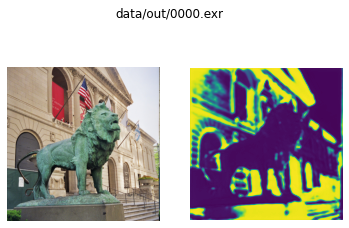

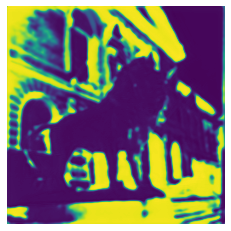

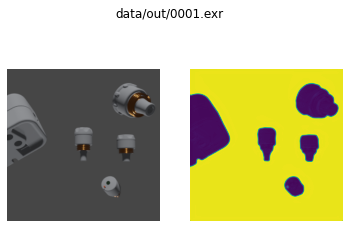

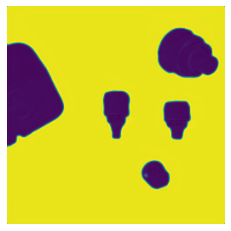

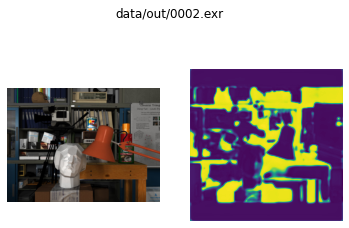

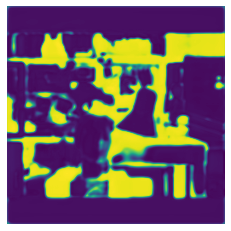

In [22]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, path in generatePredictions(model, images):
    plot_predictions([img], predictions, [path])
    save_predictions(predictions, [path])

In [15]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)